# Sign Language Digits Using MobileNet Fine-Tuned

## Import Libraries

In [61]:
import os
from glob import glob
import shutil
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

### Confusion Matix plot

In [59]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Configure Physical Devices

In [ ]:
pyshical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"Number of GPUs: {len(pyshical_devices)}")
tf.config.experimental.set_memory_growth(pyshical_devices[0], True)

## Storage Connect & Load Data Sample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
mainFold = '/content/drive/MyDrive/Colab Notebooks/Deep_Learning/MobileNet/dataset/SLD_Dataset'
os.chdir(mainFold)

In [ ]:
!wget https://github.com/ardamavi/Sign-Language-Digits-Dataset/archive/refs/heads/master.zip

--2021-07-30 16:24:53--  https://github.com/ardamavi/Sign-Language-Digits-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ardamavi/Sign-Language-Digits-Dataset/zip/refs/heads/master [following]
--2021-07-30 16:24:53--  https://codeload.github.com/ardamavi/Sign-Language-Digits-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]  16.43M  14.0MB/s    in 1.2s    

2021-07-30 16:24:54 (14.0 MB/s) - ‘master.zip’ saved [17231669]



In [ ]:
!unzip master.zip

In [ ]:
os.chdir('Sign-Language-Digits-Dataset-master')

In [ ]:
!rm -rf Examples LICENSE README.md

In [ ]:
for folder in os.listdir("Dataset"):
  shutil.move(os.path.join('Dataset', folder), mainFold)

In [ ]:
os.chdir("../")
os.listdir()

['master.zip',
 'Sign-Language-Digits-Dataset-master',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [ ]:
!rm -rf master.zip Sign-Language-Digits-Dataset-master

In [ ]:
os.listdir()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Image Pre-processing

[**Sign Language Digits Dataset**](https://github.com/ardamavi/Sign-Language-Digits-Dataset): 

  - Details of datasets: 

    - Image size: 100 x 100 pixels
    - Color space: RGB
    - Number of classes: 10 (Digits: 0-9)
    - Number of participant students: 218
    - Number of samples per student: 10


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/MobileNet/dataset/SLD_Dataset")

if os.path.isdir('train/0/') is False:
  # create our train, test, and valid folders
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')

  for folder in range(0, 10):
    # moves all the 10 folders in train folder
    shutil.move(f'{folder}', 'train')
    os.mkdir(f'valid/{folder}')
    os.mkdir(f'test/{folder}')
    #create a random list of images from each folder and insert them into valid folders
    valid_samples = random.sample(os.listdir(f'train/{folder}'), 30)
    for img in valid_samples:
      shutil.move(f'train/{folder}/{img}', f'valid/{folder}')
    
    # same thing with test folders
    test_samples = random.sample(os.listdir(f'train/{folder}'), 5)
    for img in test_samples:
      shutil.move(f'train/{folder}/{img}', f'test/{folder}')

## Train, Validation, and Test Phase

In [12]:
filePath = os.chdir("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/MobileNet/dataset/SLD_Dataset/")
train_path = os.path.abspath('train')
valid_path = os.path.abspath('valid')
test_path = os.path.abspath('test')


In [13]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [14]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50

assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

## Modify Model

In [15]:
mobNet = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [16]:
mobNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [24]:
# Check the type of the model (whehter it is Model type or Functional Type)
type(mobNet)

tensorflow.python.keras.engine.functional.Functional

 Next, we're going to grab the output <u>from the sixth to last layer</u> of the model and store it in this variable x. 

In [29]:
x = mobNet.layers[-6].output
output = Dense(units=10, activation='softmax')(x)  # pass all of the previous layers except "#x" 

 We'll be using this to build a new model. This new model will consist of the original MobileNet up to the sixth to last layer. <u>We're not including the last five layers of the original MobileNet</u>. 

## Algorithm Build Model

In [32]:
model = Model(inputs=mobNet.input, outputs=output)

Now, lets freeze the layers not to change the weights and bias of them <u>except</u> the last 23 layers – we're going to train them.

Last 23 layers after some expermintations on them, it found that it gives us a pretty decently performing model. 

In [33]:
for layer in model.layers[:-23]:
  layer.trainable = False

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

## Fitting Model

In [35]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
#Run for more epochs (~30) to see better results
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 627s - loss: 0.6356 - accuracy: 0.8113 - val_loss: 0.3479 - val_accuracy: 0.8933
Epoch 2/10
172/172 - 8s - loss: 0.1145 - accuracy: 0.9860 - val_loss: 0.1218 - val_accuracy: 0.9733
Epoch 3/10
172/172 - 8s - loss: 0.0622 - accuracy: 0.9924 - val_loss: 0.0774 - val_accuracy: 0.9867
Epoch 4/10
172/172 - 7s - loss: 0.0379 - accuracy: 0.9965 - val_loss: 0.0997 - val_accuracy: 0.9633
Epoch 5/10
172/172 - 7s - loss: 0.0229 - accuracy: 0.9977 - val_loss: 0.0557 - val_accuracy: 0.9900
Epoch 6/10
172/172 - 7s - loss: 0.0173 - accuracy: 0.9994 - val_loss: 0.0436 - val_accuracy: 0.9900
Epoch 7/10
172/172 - 7s - loss: 0.0185 - accuracy: 0.9965 - val_loss: 0.0454 - val_accuracy: 0.9800
Epoch 8/10
172/172 - 7s - loss: 0.0141 - accuracy: 0.9982 - val_loss: 0.0390 - val_accuracy: 0.9900
Epoch 9/10
172/172 - 8s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9900
Epoch 10/10
172/172 - 8s - loss: 0.0094 - accuracy: 0.9994 - val_loss: 0.0397 - val_accuracy: 0.99

## Predict Model

In [38]:
Y_hat = model.predict(x=test_batches, verbose=0)

## Model Evaluation

In [41]:
# let's get the class labels of our test data
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [44]:
# now, we need to get the class main labels to add them to the confusion matrix
classes = test_batches.class_indices.keys()
classes = list(classes)
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [46]:
# Now, let's define our confusion matrix
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(Y_hat, axis=1))

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 1 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


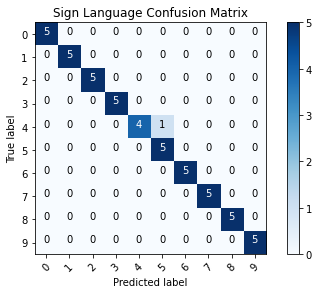

In [60]:
# Plotting the confusion matrix
plot_confusion_matrix(cm=cm, classes=classes, title='Sign Language Confusion Matrix')

In [76]:
f1_score(y_true=test_labels, y_pred=np.argmax(Y_hat, axis=1), average="micro")

0.98

## Model Export


In [80]:
if os.path.isfile("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/MobileNet/sign-language-detector.h5") is False:
  model.save(filepath="/content/drive/MyDrive/Colab Notebooks/Deep_Learning/MobileNet/sign-language-detector.h5", overwrite=False)